# Tutorial
This is the first tutorial. In this tutorial, you will get used to the Jupyter Notebooks, and the work flow. 

We start the tutorial by loading the required Python modules and setting the figure properties.

In [6]:
import numpy as np              # Numpy is the package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of our meteorological data.
import matplotlib.pyplot as pl  # Matplotlib is a scientific plotting package.

from mpl_toolkits.basemap import Basemap # Import the map plotting interface.

# The statement below enforces the plots to be put inline.
%pylab inline
pl.rcParams.update({'font.size': 12})          # Set the font size of the plots to 12pt.
pl.rcParams.update({'figure.figsize': [13,6]}) # Set the standard figure size.

Populating the interactive namespace from numpy and matplotlib


___
With the code below, you up the world map with the desired coordinates

In [7]:
lon_start = -150.
lon_end   =   50.
lat_start =   20.
lat_end   =   70.
m = Basemap(llcrnrlon=lon_start,
            llcrnrlat=lat_start,
            urcrnrlon=lon_end,
            urcrnrlat=lat_end,
            projection='mill', resolution='l')

___
Now, you load the data and read out the desired variables.

In [8]:
nc_file = nc.Dataset("data/test.nc", "r")
lat = nc_file.variables["latitude"][:]
lon = nc_file.variables["longitude"][:]
p = nc_file.variables["level"][:]*100    # Conversion of pressure to Pa.

t = -1 # Index -1 means the last index. We choose the last time index from the data.

# With the code below, we roll the map, to get the 0 meridian,
# rather than the Pacific in the middle.
nroll = lon.size//2
lon = np.roll(lon, nroll)
lon = np.where(lon>=180., lon-360., lon)

# We load the two horizontal wind components, the geopotential and the temperature.
u = np.roll(nc_file.variables["u"][t,:,:,:], nroll, -1)
v = np.roll(nc_file.variables["v"][t,:,:,:], nroll, -1)
z = np.roll(nc_file.variables["z"][t,:,:,:], nroll, -1)
T = np.roll(nc_file.variables["t"][t,:,:,:], nroll, -1)

nc_file.close() # The file access is closed as no further data is needed now.

# We create two-dimensional grids for lons and lats in degrees and radians. These arrays
# are used for plotting and computation.
lons, lats = m(*np.meshgrid(lon, lat))
lonrad, latrad = np.meshgrid(np.pi/180.*lon, np.pi/180.*lat)

___
Below, the temperature at 500 hPa is plotted.

/usr/local/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


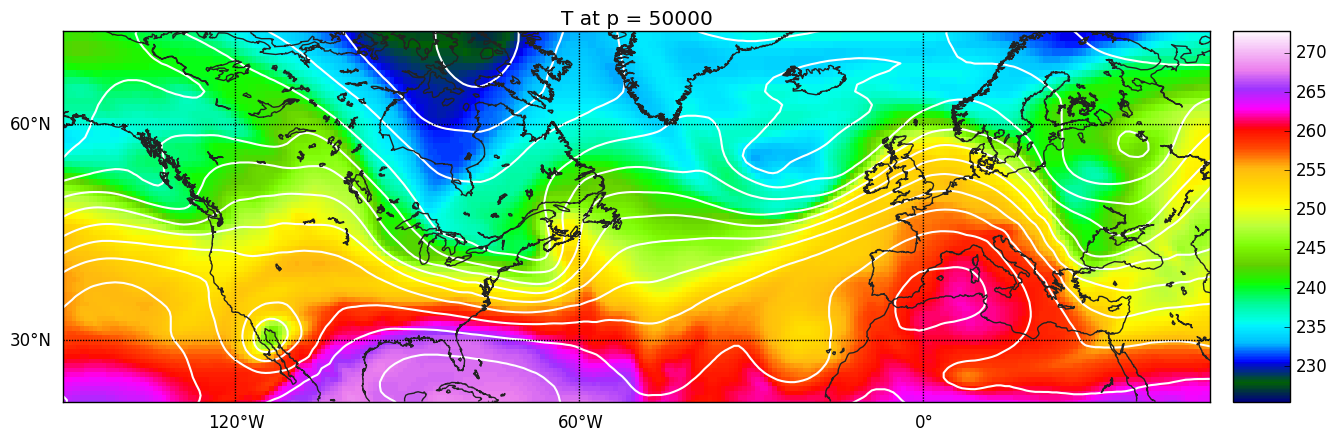

In [9]:
p_plot = 50000.            # Choose the height in pressure level at which you want to plot.
n = abs(p-p_plot).argmin() # The index closest to the desired height is chosen.

m.pcolormesh(lons, lats, T[n,:,:], cmap=pl.cm.gist_ncar)
m.colorbar()
m.contour(lons, lats, z[n,:,:], 15, colors='w', linewidths=1.5)
m.drawcoastlines(color='#222222')
# draw parallels.
parallels = np.arange(0.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('T at p = {0}'.format(p[n]));
pl.tight_layout()

___
In Python, the underlying language of the notebooks, it is very easy to do manipulations on the data. Below, we calculate for instance the total wind speed and plot it. Again, we make use of the previously defined index of the 500 hPa level `n`. We calculate the total wind speed $U$ as
$$ U = \sqrt{u^2 + v^2}$$

/usr/local/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


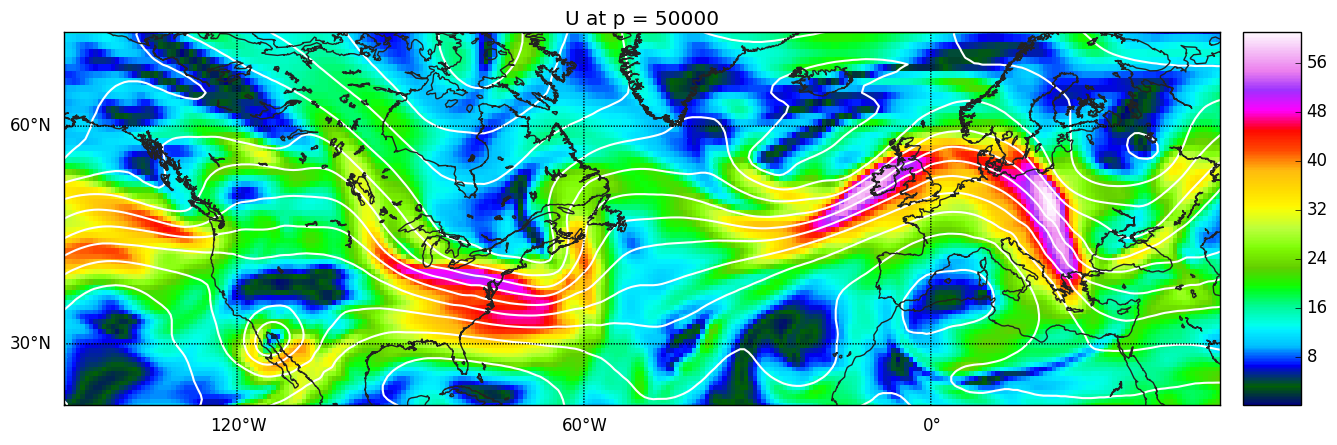

In [10]:
U = (u**2 + v**2)**.5

m.pcolormesh(lons, lats, U[n,:,:], cmap=pl.cm.gist_ncar)
m.colorbar()
m.contour(lons, lats, z[n,:,:], 15, colors='w', linewidths=1.5)
m.drawcoastlines(color='#222222')
# draw parallels.
parallels = np.arange(0.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('U at p = {0}'.format(p[n]));
pl.tight_layout()

___


In [11]:
r_earth = 6.37e6

dzdx = np.zeros(z.shape)
dzdy = np.zeros(z.shape)

cos_lat = np.cos(latrad)
for k in range(p.size):
    dzdx[k,:,:] = 1./(r_earth*cos_lat) * np.gradient(z[k,:,:], axis=1) / np.gradient(lonrad, axis=1)

for k in range(p.size):
    dzdy[k,:,:] = (1./r_earth) * np.gradient(z[k,:,:], axis=0) / np.gradient(latrad, axis=0)

omega = 7.2921e-5
f = 2.*omega*np.sin(latrad)
ug = -1./f*dzdy
vg =  1./f*dzdx
Ug = (ug**2 + vg**2)**.5

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in multiply


/usr/local/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/usr/local/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


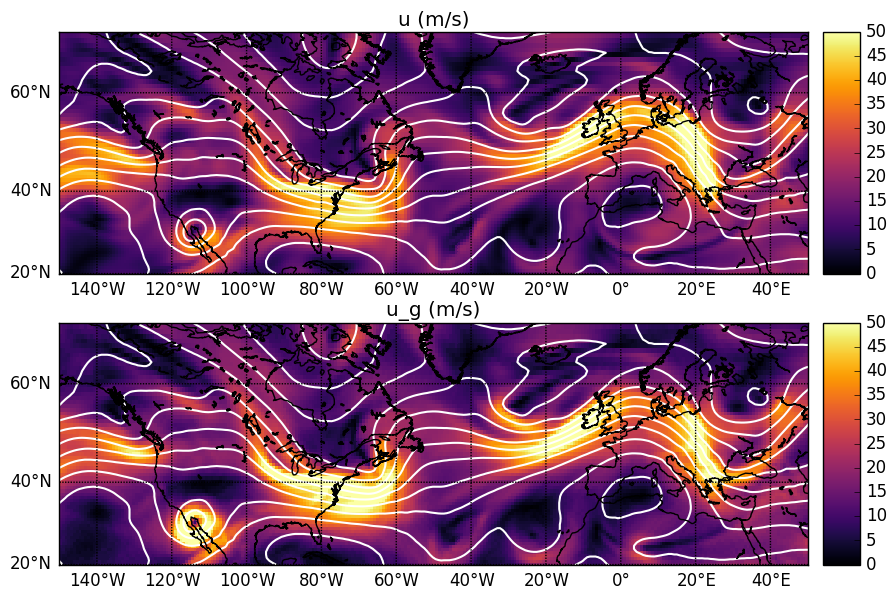

In [12]:
umin = 0.
umax = 50.
pl.subplot(211)
m.pcolormesh(lons, lats, U[n,:,:], vmin=umin, vmax=umax, cmap=pl.cm.inferno)
m.colorbar()
m.contour(lons, lats, z[n,:,:], 15, colors='w', linewidths=1.5)
m.drawcoastlines()
# draw parallels.
parallels = np.arange(0.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1]);
pl.title('u (m/s)')
pl.subplot(212)
m.pcolormesh(lons, lats, Ug[n,:,:], vmin=umin, vmax=umax, cmap=pl.cm.inferno)
m.colorbar();
m.contour(lons, lats, z[n,:,:], 15, colors='w', linewidths=1.5)
m.drawcoastlines()
# draw parallels.
parallels = np.arange(0.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1]);
pl.title('u_g (m/s)')
pl.tight_layout()

In [13]:
dTdx = np.zeros(T.shape)
dTdy = np.zeros(T.shape)

cos_lat = np.cos(latrad)
for k in range(p.size):
    for j in range(lat.size):
        dTdx[k,j,:] = 1./(r_earth*cos_lat[j,:]) * np.gradient(T[k,j,:]) / np.gradient(lonrad[j,:])

for k in range(p.size):
    for i in range(lon.size):
        dTdy[k,:,i] = (1./r_earth) * np.gradient(T[k,:,i]) / np.gradient(latrad[:,i])

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


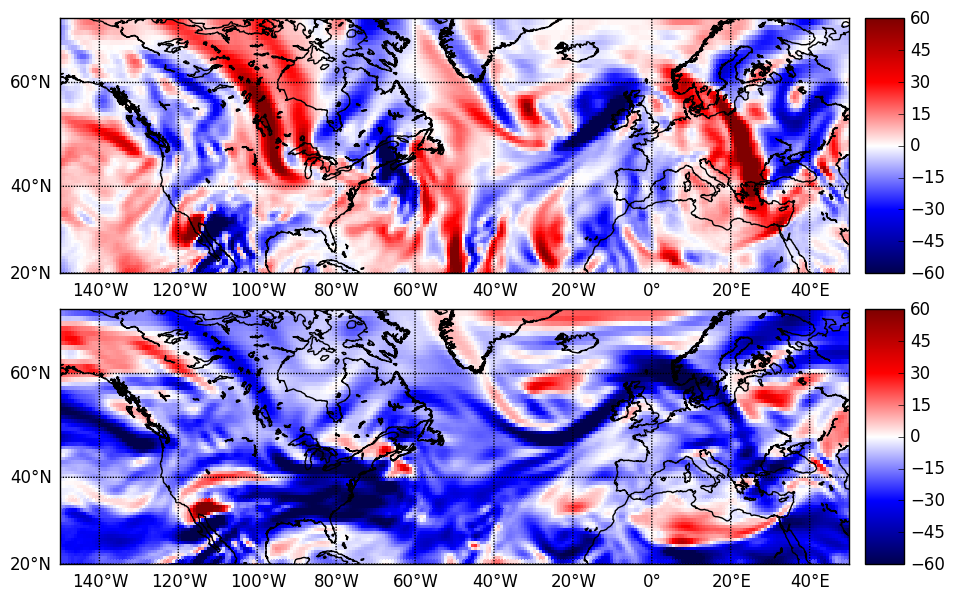

In [14]:
R = 287.
minmax=60.
pl.subplot(211)
m.pcolormesh(lons, lats, -R/f*dTdx[n,:,:], vmin=-minmax, vmax=minmax, cmap=pl.cm.seismic)
m.colorbar()
m.drawcoastlines()
# draw parallels.
parallels = np.arange(0.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1]);

pl.subplot(212)
m.pcolormesh(lons, lats,  R/f*dTdy[n,:,:], vmin=-minmax, vmax=minmax, cmap=pl.cm.seismic)
m.colorbar();
m.drawcoastlines()
# draw parallels.
parallels = np.arange(0.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1]);
pl.tight_layout()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


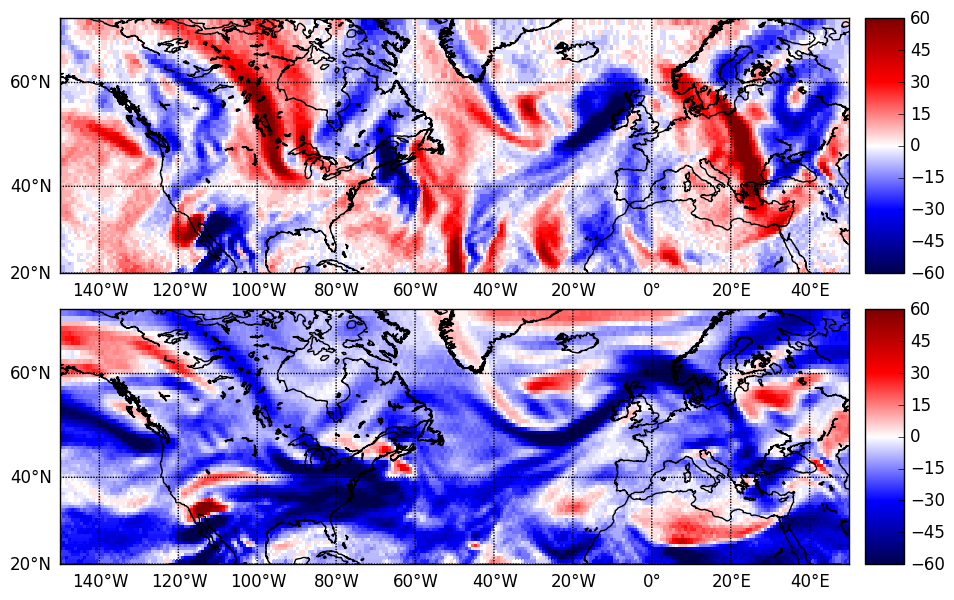

In [16]:
dvgdlnp = (vg[n+1]-vg[n-1])/(np.log(p[n+1])-np.log(p[n-1]))
dugdlnp = (ug[n+1]-ug[n-1])/(np.log(p[n+1])-np.log(p[n-1]))

pl.subplot(211)
m.pcolormesh(lons, lats, dvgdlnp, vmin=-minmax, vmax=minmax, cmap=pl.cm.seismic)
m.colorbar()
m.drawcoastlines()
# draw parallels.
parallels = np.arange(0.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1]);
pl.subplot(212)
m.pcolormesh(lons, lats, dugdlnp, vmin=-minmax, vmax=minmax, cmap=pl.cm.seismic)
m.colorbar()
m.drawcoastlines()
# draw parallels.
parallels = np.arange(0.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1]);
pl.tight_layout()

In [ ]:
m.pcolormesh(lons, lats, dvgdlnp+R/f*dTdx[n,:,:], vmin=-minmax, vmax=minmax, cmap=pl.cm.seismic)
m.colorbar();
m.drawcoastlines()
# draw parallels.
parallels = np.arange(0.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1]);
pl.tight_layout()

In [ ]:
minmax=20.
m.pcolormesh(lons, lats, U[n,:,:]-Ug[n,:,:], vmin=-minmax, vmax=minmax, cmap=pl.cm.RdBu)
m.colorbar();
m.contour(lons, lats, z[n,:,:], 12, colors='k')
m.drawcoastlines()
# draw parallels.
parallels = np.arange(0.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1]);
pl.title('ua = u - ug (m/s)')
pl.tight_layout()

In [ ]:
div = np.zeros(lons.shape)
for j in range(lat.size):
    div[j,:]  = 1./(r_earth*cos_lat[j,:]) * np.gradient(ug[n,j,:]) / np.gradient(lonrad[j,:])
for i in range(lon.size):
    div[:,i] += (1./r_earth) * np.gradient(vg[n,:,i]) / np.gradient(latrad[:,i])

In [ ]:
minmax = 0.5
m.pcolormesh(lons, lats, 1e5*div, cmap=pl.cm.RdBu, vmin=-minmax, vmax=minmax)
m.colorbar();
m.contour(lons, lats, z[n,:,:], 12, colors='k')
m.drawcoastlines()
# draw parallels.
parallels = np.arange(0.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1]);
pl.title('div * 1e5 (1/s)')
pl.tight_layout()

In [ ]:
Ug_masked = np.ma.masked_array(Ug, abs(Ug)<5.)
error_range = np.linspace(0., 0.5, 6)
m.contourf(lons, lats, abs( (U[n,:,:]-Ug_masked[n,:,:])/Ug_masked[n,:,:] ), error_range, extend='max', cmap=pl.cm.inferno_r)
m.colorbar();
m.contour(lons, lats, z[n,:,:], 12, colors='w', linewidths=1.5)
m.drawcoastlines(color='k')
# draw parallels.
parallels = np.arange(0.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1]);
pl.title('U_a/U_g')
pl.tight_layout()